In [2]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from hiive.mdptoolbox import example, mdp
from toh_gym.envs import TohEnv
from tqdm import tqdm

In [3]:
#P, R = example.forest(S=100, r1=10, r2=5, p=0.001)
# P, R = example.rand(10000, 4)

In [4]:
def getTransitionAndReward(env):
    nA, nS = env.nA, env.nS
    T = np.zeros([nA, nS, nS])
    R = np.zeros([nS, nA])
    for s in range(nS):
        for a in range(nA):
            transitions = env.P[s][a]
            for p_trans, next_s, reward, _ in transitions:
                T[a,s,next_s] += p_trans
                R[s,a] = reward
            T[a,s,:] /= np.sum(T[a,s,:])
    return T, R

In [5]:
def simulateGymEnv(env, policy, numEpisodes, max_iters=1000):
    rewards = []
    lengths = []
    failed = 0
    for i in range(numEpisodes):
        env.reset()
        state = 0
        done = False
        count = 0
        reward_sum = 0

        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            count += 1
            
            if count > max_iters:
                failed += 1
                break
        
        lengths.append(count)
        rewards.append(reward_sum)
    return lengths, rewards

In [6]:
def plotStats(lengths, rewards):
    count = 0
    for i in rewards:
        if i == 1.0:
            count += 1
    print(count / len(rewards))
    
    # Total reward per episode and average reward per step for each episode
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0][0].plot(x, rewards)
    axes[0][0].set_xlabel('Episode')
    axes[0][0].set_ylabel('Total Reward')
    axes[0][0].grid()

    avg_reward = [rewards[i] / lengths[i] for i in range(len(rewards))]
    axes[0][1].plot(x, avg_reward)
    axes[0][1].set_xlabel('Episode')
    axes[0][1].set_ylabel('Avg. Reward per Step')
    axes[0][1].grid()
    
    axes[1][0].plot(x, lengths)
    axes[1][0].set_xlabel('Episode')
    axes[1][0].set_ylabel('Steps')
    axes[1][0].grid()
    

In [7]:
env = TohEnv(poles=3, rings=6, noise=0.1)
T, R = getTransitionAndReward(env)

In [8]:
env.action_list

array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 2],
       [2, 0],
       [2, 1]])

In [9]:
env.reset()
env.render()


      ||            ||            ||      
      ||            ||            ||      
      ||            ||            ||      
     ~||~           ||            ||      
    ~~||~~          ||            ||      
   ~~~||~~~         ||            ||      
  ~~~~||~~~~  ~~~~~~||~~~~~~ ~~~~~||~~~~~ 
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾


In [10]:
#try varying gammas from 0 to 1
#at 0 the agent only considers immediate rewards
#at 1 the agent considers all futures rewards equally
gammas = np.arange(0.95, 0.99, 0.01)
print(gammas)

[0.95 0.96 0.97 0.98 0.99]


## Value Iteration

0.95 0.172 0.0005263157894736847
0.96 0.16 0.000416666666666667
0.97 0.166 0.0003092783505154642
0.98 0.188 0.0002040816326530614
0.99 0.198 0.00010101010101010109


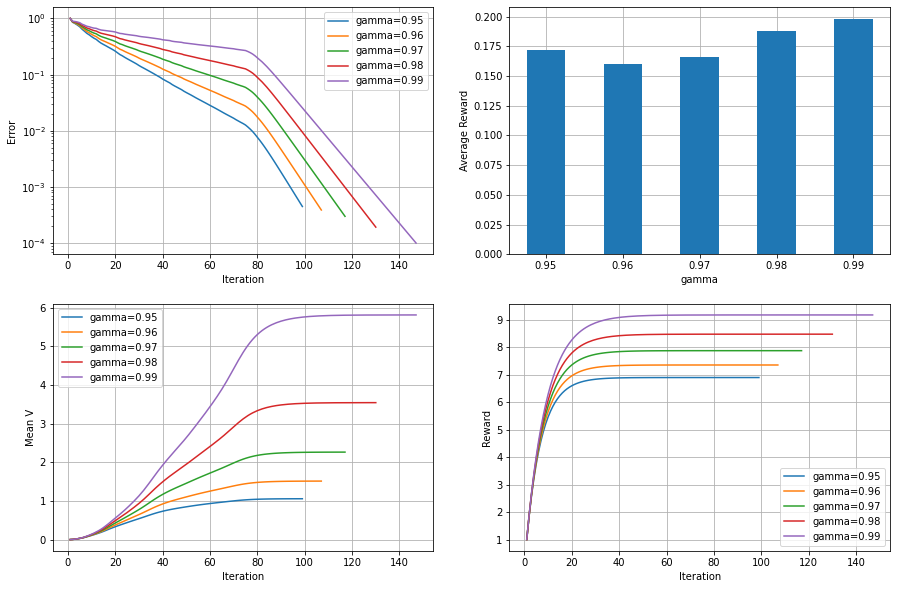

In [78]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
avg_rewards = []
for gamma in gammas:
    vi = mdp.ValueIteration(T, R, gamma)
    vi.verbose = False
    vi.run()
    episodes = 500
    x = range(episodes)
    vi_lengths, vi_rewards = simulateGymEnv(env, vi.policy, episodes)
    print(gamma, sum(vi_rewards) / episodes, vi.thresh)
    avg_rewards.append(sum(vi_rewards) / episodes)
   
    # Policy change per iteration
    ax[0][0].semilogy(range(1, vi.iter + 1), [run['Error'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()
    
    ax[1][0].plot(range(1, vi.iter + 1), [run['Mean V'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()
    
    ax[1][1].plot(range(1, vi.iter + 1), [run['Reward'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()

# Time
ax[0][1].bar(gammas, avg_rewards, width=0.005)
ax[0][1].set_xlabel('gamma')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].set_axisbelow(True)
ax[0][1].grid()

plt.show()

In [76]:
vi = mdp.ValueIteration(T, R, 0.99, epsilon=0.01)
vi.run()
print(vi.iter, vi.time)
print(vi.policy)

147 0.0330510139465332
(0, 1, 5, 3, 4, 1, 0, 3, 2, 4, 3, 5, 2, 1, 2, 0, 3, 0, 4, 1, 5, 1, 0, 4, 5, 5, 2, 3, 4, 1, 2, 5, 2, 0, 4, 0, 3, 4, 5, 3, 2, 4, 5, 1, 0, 4, 0, 3, 0, 5, 2, 1, 5, 1, 2, 1, 5, 0, 3, 3, 4, 0, 4, 3, 4, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 3, 2, 1, 2, 3, 2, 4, 3, 5, 2, 1, 2, 0, 3, 0, 4, 4, 5, 1, 0, 4, 5, 3, 2, 3, 0, 4, 0, 1, 2, 1, 5, 5, 2, 1, 5, 0, 4, 3, 4, 0, 3, 3, 4, 4, 5, 5, 2, 1, 2, 3, 2, 1, 5, 1, 0, 1, 2, 3, 2, 0, 3, 0, 4, 1, 5, 1, 2, 1, 5, 5, 2, 3, 4, 0, 4, 3, 4, 0, 3, 1, 0, 3, 2, 4, 5, 3, 2, 1, 0, 3, 2, 4, 5, 1, 0, 4, 3, 4, 0, 4, 3, 3, 0, 5, 2, 1, 2, 5, 2, 1, 5, 5, 2, 1, 2, 1, 2, 1, 5, 0, 3, 0, 4, 0, 3, 3, 4, 0, 3, 0, 4, 0, 4, 3, 4, 1, 5, 1, 0, 4, 5, 5, 2, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 1, 0, 4, 5, 5, 2, 4, 5, 5, 2, 1, 2, 3, 2, 3, 4, 1, 2, 5, 2, 0, 4, 0, 3, 4, 5, 3, 2, 4, 5, 1, 0, 4, 0, 3, 0, 5, 2, 1, 5, 1, 2, 1, 5, 0, 3, 3, 4, 0, 4, 3, 4, 1, 5, 1, 0, 1, 2, 3, 2, 4, 5, 5, 2, 1, 2, 3, 2, 0, 4, 0, 3, 1, 5, 5, 2, 1, 5, 1, 2, 3, 4, 0, 3, 3, 4, 0, 4, 1, 0, 3, 2, 4, 5, 1, 0, 1

In [44]:
episodes = 100
x = range(episodes)

vi_lengths, vi_rewards = simulateGymEnv(env, vi.policy, episodes)

0.16


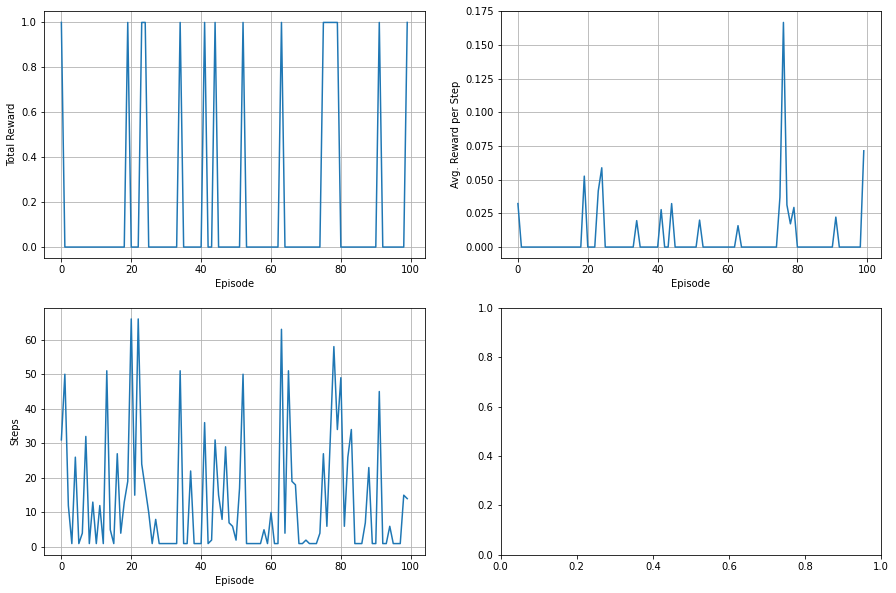

In [45]:
plotStats(vi_lengths, vi_rewards)

## Policy Iteration

0.95 0.18
0.96 0.198
0.97 0.19
0.98 0.214
0.99 0.208


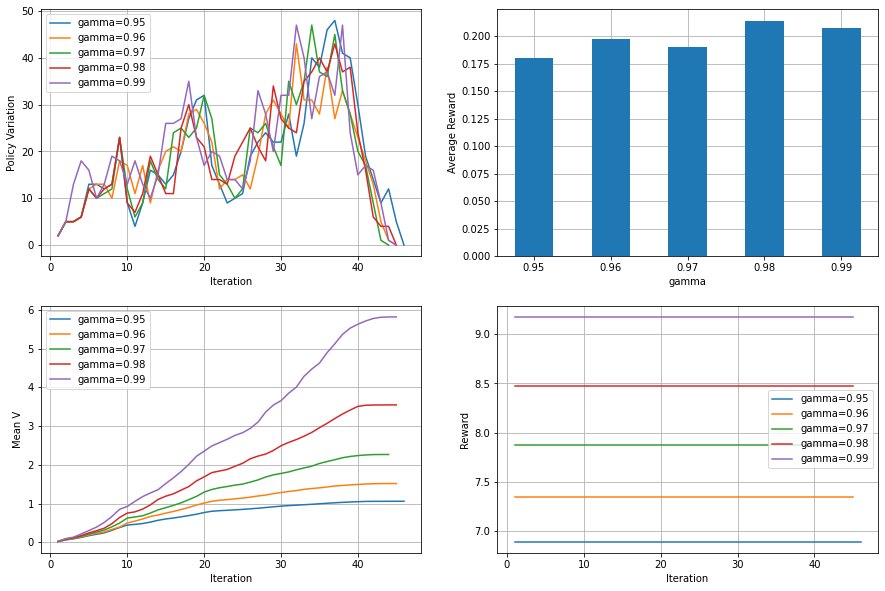

In [79]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
avg_rewards = []
for gamma in gammas:
    pi = mdp.PolicyIteration(T, R, gamma)
    pi.run()
    episodes = 500
    x = range(episodes)
    pi_lengths, pi_rewards = simulateGymEnv(env, pi.policy, episodes)
    print(gamma, sum(pi_rewards) / episodes)
    avg_rewards.append(sum(pi_rewards) / episodes)
    
    # Policy change per iteration
    ax[0][0].plot(range(1, pi.iter + 1), pi.variation, label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Policy Variation')
    ax[0][0].grid()
    ax[0][0].legend()
    
    ax[1][0].plot(range(1, pi.iter + 1), [run['Mean V'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()
    
    ax[1][1].plot(range(1, pi.iter + 1), [run['Reward'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
# Time
ax[0][1].bar(gammas, avg_rewards, width=0.005)
ax[0][1].set_xlabel('gamma')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].set_axisbelow(True)
ax[0][1].grid()

plt.show()

In [47]:
pi = mdp.PolicyIteration(T, R, 0.99)
pi.run()
print(pi.iter, pi.time)

45 1.8566508293151855


In [48]:
episodes = 100
x = range(episodes)

pi_lengths, pi_rewards = simulateGymEnv(env, pi.policy, episodes)

In [49]:
print(pi.policy)

(0, 1, 5, 3, 4, 1, 0, 3, 2, 4, 3, 5, 2, 1, 2, 0, 3, 0, 4, 1, 5, 1, 0, 4, 5, 5, 2, 3, 4, 1, 2, 5, 2, 0, 4, 0, 3, 4, 5, 3, 2, 4, 5, 1, 0, 4, 0, 3, 0, 5, 2, 1, 5, 1, 2, 1, 5, 0, 3, 3, 4, 0, 4, 3, 4, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 3, 2, 1, 2, 3, 2, 4, 3, 5, 2, 1, 2, 0, 3, 0, 4, 4, 5, 1, 0, 4, 5, 3, 2, 3, 0, 4, 0, 1, 2, 1, 5, 5, 2, 1, 5, 0, 4, 3, 4, 0, 3, 3, 4, 4, 5, 5, 2, 1, 2, 3, 2, 1, 5, 1, 0, 1, 2, 3, 2, 0, 3, 0, 4, 1, 5, 1, 2, 1, 5, 5, 2, 3, 4, 0, 4, 3, 4, 0, 3, 1, 0, 3, 2, 4, 5, 3, 2, 1, 0, 3, 2, 4, 5, 1, 0, 4, 3, 4, 0, 4, 3, 3, 0, 5, 2, 1, 2, 5, 2, 1, 5, 5, 2, 1, 2, 1, 2, 1, 5, 0, 3, 0, 4, 0, 3, 3, 4, 0, 3, 0, 4, 0, 4, 3, 4, 1, 5, 1, 0, 4, 5, 5, 2, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 1, 0, 4, 5, 5, 2, 4, 5, 5, 2, 1, 2, 3, 2, 3, 4, 1, 2, 5, 2, 0, 4, 0, 3, 4, 5, 3, 2, 4, 5, 1, 0, 4, 0, 3, 0, 5, 2, 1, 5, 1, 2, 1, 5, 0, 3, 3, 4, 0, 4, 3, 4, 1, 5, 1, 0, 1, 2, 3, 2, 4, 5, 5, 2, 1, 2, 3, 2, 0, 4, 0, 3, 1, 5, 5, 2, 1, 5, 1, 2, 3, 4, 0, 3, 3, 4, 0, 4, 1, 0, 3, 2, 4, 5, 1, 0, 1, 0, 3, 2, 4, 5, 3, 2, 

0.16


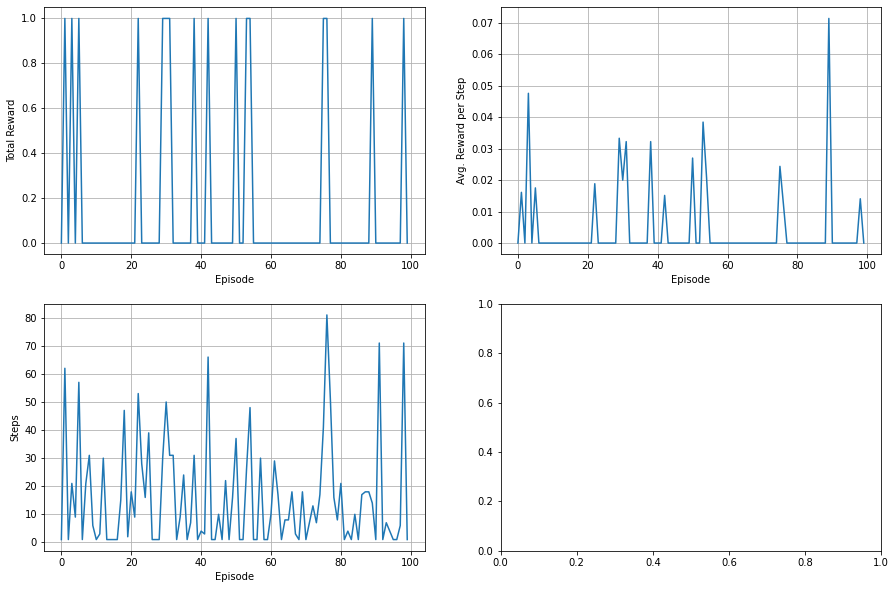

In [50]:
plotStats(pi_lengths, pi_rewards)

In [13]:
# epsilons = np.geomspace(0.01, 0.99, 5)
# print(epsilons)
# alphas = np.geomspace(0.001, 0.9, 10)
# print(alphas)
# decays = np.geomspace(0.99, 0.9999999, 10)
# print(decays)

# total = len(epsilons) * len(alphas) * len(decays) * len(gammas)
# print(total)

# params = []
# for gamma in gammas:
#     for alpha in alphas:
#         for decay in decays:
#             for epsilon in epsilons:
#                 params.append((gamma, alpha, decay, epsilon))
# print(len(params))

alphas = [0.1, 0.01, 0.001]
params = []
for alpha in alphas:
    params.append((0.99, alpha, 0.999999, 0.95))
print(len(params))

3


In [51]:
def runQLearning(params):
    gamma, alpha, decay, epsilon = params
    q = mdp.QLearning(T, R, gamma, n_iter=100000000, 
                      epsilon=epsilon, epsilon_decay=decay,
                      alpha=alpha, alpha_decay=decay,
                      run_stat_frequency=1000000)
    q.run()
    return (q, {'gamma': gamma, 'alpha': alpha, 'epsilon': epsilon, 'decay': decay})

In [ ]:
from multiprocessing import Pool

try:
    pool = Pool()
    q_policies = pool.map(runQLearning, params)
finally:
    pool.close()
    pool.join()

In [ ]:
q_policies = [i for i in q_policies]

In [66]:
max_reward = 0
best_policy = []
episodes = 100
x = range(episodes)
for policy in tqdm(q_policies):
    q_lengths, q_rewards = simulateGymEnv(env, policy[0], episodes, max_iters=1000)
    reward = sum(q_rewards)
    if reward > max_reward:
        max_reward = reward
        best_policy = [policy]
    elif reward == max_reward:
        best_policy.append(policy)

100%|██████████| 2500/2500 [00:26<00:00, 95.69it/s] 


In [67]:
print(max_reward, best_policy)

35.0 [((0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 1, 0), {'gamma': 0.96, 'alpha': 0.19849253305842324, 'epsilon': 0.01, 'decay': 0.9999999})]


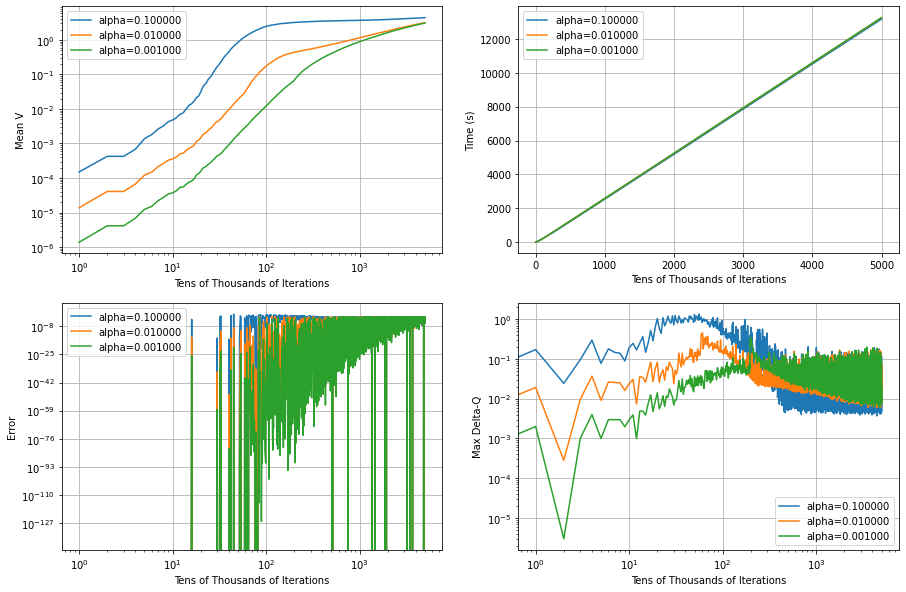

In [25]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
for q in q_policies:
    alpha = q[1]['alpha']
    q = q[0]
    stat_iters = len(q.run_stats)
    q_mean_v = [stats['Mean V'] for stats in q.run_stats]
    q_error = [stats['Error'] for stats in q.run_stats]
    q_time = [stats['Time'] for stats in q.run_stats]

    # mean v per iteration
    ax[0][0].loglog(range(1, stat_iters + 1), q_mean_v, label="alpha=%f" % alpha)
    ax[0][0].set_xlabel('Tens of Thousands of Iterations')
    ax[0][0].set_ylabel('Mean V')
    ax[0][0].grid()
    ax[0][0].legend()
    # Time
    ax[0][1].plot(range(1, stat_iters + 1), q_time, label="alpha=%f" % alpha)
    ax[0][1].set_xlabel('Tens of Thousands of Iterations')
    ax[0][1].set_ylabel('Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].loglog(range(1, stat_iters + 1), q_error, label="alpha=%f" % alpha)
    ax[1][0].set_xlabel('Tens of Thousands of Iterations')
    ax[1][0].set_ylabel('Error')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].loglog(range(len(q.variation)), q.variation, label="alpha=%f" % alpha)
    ax[1][1].set_xlabel('Tens of Thousands of Iterations')
    ax[1][1].set_ylabel('Max Delta-Q')
    ax[1][1].grid()
    ax[1][1].legend()

plt.show()

In [43]:
# q_optimal = mdp.QLearning(T, R, 0.99, n_iter=2000000,
#                           epsilon=0.95,
#                           epsilon_decay=0.999999,
#                           alpha=0.1,
#                           alpha_decay=1.0,
#                           run_stat_frequency=10000)
# q_optimal.run()

q_optimal = q_policies[2][0]
print(q_optimal.policy)
print(q_policies[0][1])

(0, 1, 5, 3, 4, 1, 0, 3, 2, 4, 3, 5, 2, 1, 2, 0, 3, 0, 4, 1, 5, 1, 0, 4, 0, 5, 2, 3, 4, 1, 2, 5, 2, 0, 4, 0, 3, 4, 5, 3, 2, 4, 5, 1, 0, 4, 0, 3, 0, 5, 2, 1, 5, 1, 2, 1, 5, 0, 3, 3, 4, 0, 4, 3, 4, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 3, 2, 1, 2, 3, 2, 4, 4, 5, 2, 0, 2, 0, 1, 0, 4, 4, 5, 1, 0, 4, 5, 3, 2, 3, 3, 4, 0, 1, 2, 1, 5, 5, 2, 1, 5, 0, 4, 3, 4, 0, 3, 3, 4, 4, 5, 5, 2, 1, 2, 3, 2, 1, 5, 1, 0, 1, 2, 3, 2, 0, 3, 0, 4, 1, 5, 1, 2, 1, 5, 5, 2, 3, 2, 1, 4, 3, 4, 0, 3, 1, 0, 3, 2, 4, 2, 3, 2, 1, 0, 3, 2, 4, 5, 1, 0, 4, 3, 4, 0, 4, 3, 3, 0, 5, 2, 3, 2, 5, 5, 1, 5, 5, 2, 1, 2, 1, 2, 1, 5, 0, 3, 0, 4, 0, 3, 3, 4, 0, 3, 0, 4, 0, 4, 3, 4, 1, 5, 1, 0, 4, 5, 5, 2, 1, 5, 1, 0, 1, 0, 3, 2, 4, 5, 1, 0, 4, 5, 5, 2, 4, 5, 5, 2, 1, 2, 3, 2, 3, 2, 1, 2, 1, 3, 5, 4, 0, 2, 4, 5, 3, 2, 4, 5, 5, 4, 0, 0, 3, 1, 5, 2, 1, 5, 1, 2, 3, 0, 0, 3, 3, 2, 0, 4, 2, 5, 1, 5, 1, 0, 1, 2, 3, 2, 4, 5, 5, 2, 5, 2, 0, 4, 5, 4, 0, 3, 2, 4, 5, 2, 1, 5, 1, 3, 3, 2, 0, 1, 3, 4, 0, 4, 1, 0, 3, 2, 4, 5, 1, 0, 1, 0, 3, 1, 4, 5, 3, 2, 

In [49]:
episodes = 500
x = range(episodes)

q_lengths, q_rewards = simulateGymEnv(env, q_optimal.policy, episodes, max_iters=1000)

0.09


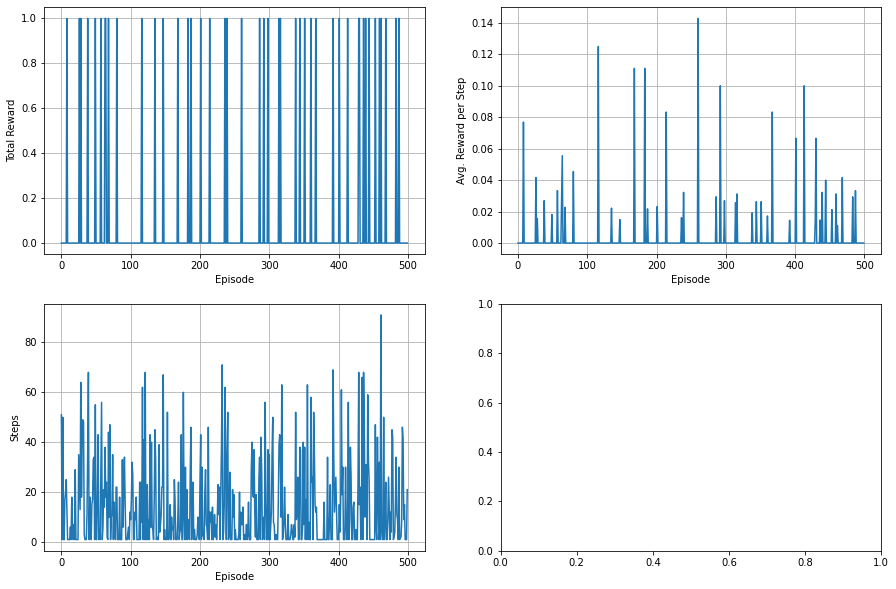

In [50]:
plotStats(q_lengths, q_rewards)

In [44]:
print(q_optimal.time)

13251.004650592804
